Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE"

Do not edit or insert code into the test cells as all you insert will be overwritten by the automated testing code.

---

### Fit 3D lines to cylinders
This project aims at fitting lines in 3D to data consisting of cylinders (produced by individual Geiger counters). Each cylinder is hence centred around an individual wire (parallel to the z-axis) on a regular grid and has a fixed radius. The cylinder height corresponds to a fixed z-coordinate error. The radius also has an error (at 10% of the radius value or at least 0.5 mm).

You have access to a file containing 10 events. The format is defined below. Each event contains data corresponding to two
lines. Each line originates from a simulated electron, each starting at the `x=0` plane from the same point, one emitted to the
left, i.e. negative x-coordinates, one to the right, with positive x-coordinates. Coordinates are given in millimetres.

The file arrives in compressed form. You can read it as given using `np.loadtxt(filename, delimiter=',')`. The column entries (and type) are
- Event number (int, starting at value 1)
- Line number (int, starting at value 1)
- Wire x-coordinate (float)
- Wire y-coordinate (float)
- Wire z-coordinate (float)
- Radius (float)
- Radius error (float)
- Wire z-coordinate error (float)

An example event is shown in the figure below. For your own figure, note that the matplotlib.pyplot library has a `pyplot.Circle((x, y), radius, fill=False, lw=2)` function that can be added as a 'patch' to a figure.

![evt](SNLRtracks.png)

The formula describing the distance of a line to a cylinder is 

$$D = \left| (\vec{x}_{p}-\vec{x}_{0}) \times{}  \vec{u} \right| - r$$

where $\vec{u}$ is the unit direction vector of the line and $\vec{x}_{0}$ is a point on the line. This assumes the line is not parallel to the y-z plane like in this exercise. The residuals between model and data also come with a weighting factor, made from the data errors, $\delta{}r$ and $\delta{}z$ according to 

$$W = \left[\sqrt{ (\delta{}z\ u_{z})^{2} + (\delta{}z\ u_{y})^{2} + (\delta{}r\ u_{z})^{2} + (\delta{}z\ u_{x})^{2} + (\delta{}r\ u_{y})^{2} + (\delta{}r\ u_{x})^{2}}\right]^{-1}$$

where $u_{x,y,z}$ represents the three components of the unit vector.

**Project**: Write an application that 
1. reads the data and 
2. fits lines to all events, 
3. counts and returns the number of successful fits, 
4. stores your results in a file with the format given below and finally 
5. plots the first event following the plot format from the example picture above.

The given code in the cell should be incorporated into your solution since its function names will be used in the tests. The `runFit(infile, outfile)` function should steer the execution of the entire code with the benefit that it can be used to measure the execution time (will be done in the test, but also useful for yourself). The `readData(filename)` function is independent of the file content and can read the compressed files, for testing or later for assessment. Two data files will be supplied for the project for your own testing. One contains 10 events in the right data format and one contains truth information (as human readable file) for checking your own code. The model solution fits all 10 events correctly.

**Hint**: The data in the file has been created with an intercept in the z-coordinate at 0.0 in order to stabilize the fits a little and simplify your task. Note that you should not take that insight as a fixed parameter (would lead to a reduction of marks) but as a reassurance to test your attempts relatively easily. The assessment data file also has the creation intercept set at `z=0` for all events.

**Hint 2**: The errors on the intercept in z and the slope in the x-z plane are likely to be big, occasionally. Not to worry, this reflects the large error on the z-coordinate which can induce a broad minimum and hence big errors. This observation simply is in the nature of the data.

Output format for fit results:
- Event number (int, starting at 1)
- Line number (int, starting at value 1)
- intercept in y (float)
- error on intercept in y (float)
- slope in x-y plane (float)
- error on slope in x-y plane (float)
- intercept in z (float)
- error on intercept in z (float)
- slope in x-z plane (float)
- error on slope in x-z plane (float)

On storing results: it is important that every line in every event has a result, even for failed hits in order to enable the comparison for your assessment. A failed fit should therefore store a result as

```python
datastore.append((evtnr, linenr, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0))
```

with `evtnr` the event number (int) and `linenr` the line number (int).

#### Marking
In all likelihood, not all fits will be successful. The model solution achieves a 98% efficiency. Your code will be run on a larger data file with 1000 events on the assessment workstation. 10 out of 20 marks will be awarded for solutions reaching 98% or higher efficiency (with the caveat of manually checking the code for correctness, of course). Note that your code efficiency will be cross checked with the truth data, i.e. the slopes and intercepts which produced each event. A successful fit for the assessment will hence have to satisfy a comparison between your parameter fit solutions and the truth values within the errors of your fit results.

Further 5 marks are awarded for the correct plot, i.e. similar to the example picture, plot the x-y plane with data Circles and your fit solution line (in that 2D plane). The final marks are awarded for any successful effort on speeding up the execution time compared to the pure, serial Python solution. Fitting 1000 events takes a fairly long time (a bit more than 15 minutes on my humble machine) hence any successful speed optimization is appreciated with up to 5 marks. Optimization can bring the time down to 40 s but at the expense of efficiency. The 98% efficiency was achieved in about 95 s.

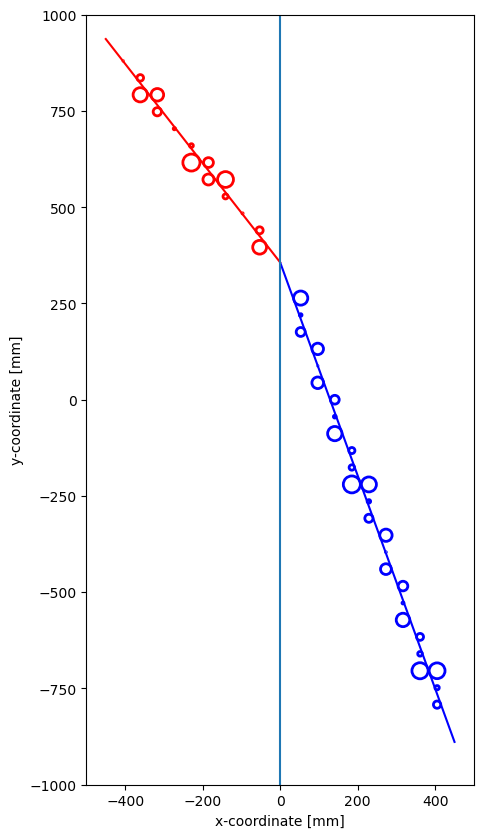

In [1]:
'''
Fit 3D lines to cylinders
'''

# YOUR CODE HERE
#from concurrent.futures import ThreadPoolExecutor
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from numpy.polynomial.polynomial import Polynomial

Y_ERR_TOL = 100

def Weight(unit, rErr, zErr):
    '''
    This is the weighting function.
    '''
    return 1/np.linalg.norm(np.concatenate([
        np.vstack(rErr)*unit.T,
        np.vstack(zErr)*unit.T
    ], axis=1), axis=1)

def Dist(x_p, x_0, unit, r):
    '''
    Distance between line and cylinder.
    '''
    xpShape = np.shape(x_p)
    X0 = np.broadcast_to(x_0, xpShape)
    Units = np.broadcast_to(unit, xpShape)
    return np.linalg.norm(np.cross(x_p - X0, Units), axis=1) - r

def f(x, wirePos, r, rErr, zErr):
    '''
    This is the weighted residual function to minimize.
    '''
    y_0, m_xy, z_0, m_xz = x
    bv = np.array([0, y_0, z_0]) # Fixed vector
    unit = np.array([1, m_xy, m_xz]) # Direction vector
    unit /= np.linalg.norm(unit)
    return Weight(unit, rErr, zErr) * Dist(wirePos, bv, unit, r)

def analyseEvent(event):
    '''
    Takes file line entries corresponding to a particular event.
    Returns:
    the number of successful fits,
    T, T where T = [
        eventNumber, lineNumber,
        yIntercept, yInterceptErr,
        xySlope, xySlopeErr,
        zIntercept, zInterceptErr,
        xzSlope, xzSlopeErr
    ], the data for both lines.
    '''
    lines = (event[event[:,1] == 1], event[event[:,1] == 2])
    eventNumber = int(lines[0][0][0])
    linesData = [
        [eventNumber, 1, 0., 0., 0., 0., 0., 0., 0., 0.],
        [eventNumber, 2, 0., 0., 0., 0., 0., 0., 0., 0.],
    ]
    successes = 0

    for line in range(2):
        lineData = lines[line]
        wirePos = lineData[:,[2,3,4]]
        r = lineData[:,5]
        rErr = lineData[:,6]
        zErr = lineData[:,7]

        ref = wirePos[0]
        dirGuess = (wirePos[-1] - ref)
        xySlopeGuess = dirGuess[1]/dirGuess[0]
        xzSlopeGuess = dirGuess[2]/dirGuess[0]
        yInterceptGuess = ref[1] - xySlopeGuess*ref[0]
        zInterceptGuess = ref[2] - xzSlopeGuess*ref[0]
        init = (yInterceptGuess, xySlopeGuess, zInterceptGuess, xzSlopeGuess)
        args = (wirePos, r, rErr, zErr)
        sol = least_squares(f, init, args=args, jac="3-point")

        if sol.success:
            yIntercept, xySlope, zIntercept, xzSlope = sol.x
            errors = np.sqrt(np.diag(np.linalg.inv(sol.jac.T @ sol.jac)))
            yInterceptErr, xySlopeErr, zInterceptErr, xzSlopeErr = errors

            if yInterceptErr <= Y_ERR_TOL:
                linesData[line] = [
                    eventNumber, line+1,
                    yIntercept, yInterceptErr,
                    xySlope, xySlopeErr,
                    zIntercept, zInterceptErr,
                    xzSlope, xzSlopeErr
                ]
                successes += 1
        else: # Polyfit for initial values as last resort.
            yInterceptGuess, xySlopeGuess = Polynomial.fit(
                wirePos[:,0],
                wirePos[:,1],
                1
            ).convert()
            zInterceptGuess, xzSlopeGuess = Polynomial.fit(
                wirePos[:,0],
                wirePos[:,2],
                1
            ).convert()

            init = (
                yInterceptGuess,
                xySlopeGuess,
                zInterceptGuess,
                xzSlopeGuess
            )
            sol = least_squares(f, init, args=args, jac="3-point")
            if sol.success:
                yIntercept, xySlope, zIntercept, xzSlope = sol.x
                errors = np.sqrt(np.diag(np.linalg.inv(sol.jac.T @ sol.jac)))
                yInterceptErr, xySlopeErr, zInterceptErr, xzSlopeErr = errors
                if yInterceptErr <= Y_ERR_TOL:
                    linesData[line] = [
                        eventNumber, line+1,
                        yIntercept, yInterceptErr,
                        xySlope, xySlopeErr,
                        zIntercept, zInterceptErr,
                        xzSlope, xzSlopeErr
                    ]
                    successes += 1

    return successes, linesData

def readData(filename):
    '''
    Read compressed data.
    '''
    return np.loadtxt(filename, delimiter=',')

def runFit(inputfilename, outputfilename):
    '''

    Parameters
    ----------
    inputfilename : string
        input data file name for fitting.
    outputfilename : string
        result storage file name.

    Returns
    -------
    counter : int
        number of successful fits; 100% would be twice the number
        of events (two lines per event).

    '''
    fulldata = readData(inputfilename)

    counter = 0

# YOUR CODE HERE
    eventCount = int(fulldata[:,0].max())
    events = [fulldata[fulldata[:,0] == i] for i in range(1, eventCount+1)]

    #with ThreadPoolExecutor() as executor:
        #data = executor.map(analyseEvent, events)
    data = map(analyseEvent, events)
    # For whatever reason using regular map() is faster for this data than
    # the threaded map.
    # Will keep these lines commented for posterity, perhaps it would improve
    # performance for a large number of events but without the test data
    # I cannot verify this.

    fileOutput = []

    for eventData in data:
        counter += eventData[0]
        l1, l2 = eventData[1]
        fileOutput.append(l1)
        fileOutput.append(l2)

    fmt = "%d, %d, %.6f, %.6f, %.6f, %.6f, %.6f, %.6f, %.6f, %.6f"
    np.savetxt(outputfilename, fileOutput, fmt=fmt)

    return counter

# run the code and plot the figure
#import time
# YOUR CODE HERE
#start = time.process_time()
#count = runFit("tendata.txt.gz", "tenfit.txt")
#stop = time.process_time()

runFit("tendata.txt.gz", "tenfit.txt")

#print("Time (s): ", stop - start)
#print("Efficiency (%): ", 100*count/20)

# Only pick the data for the first event.
fileData = readData("tendata.txt.gz")
fileData = fileData[fileData[:,0] == 1]
fitData = readData("tenfit.txt")
fitData = fitData[fitData[:,0] == 1]

wires = fileData[:,[2,3]]
radius = fileData[:,5]

fig, axes = plt.subplots(figsize=(5,10))

plt.xlabel("x-coordinate [mm]")
plt.ylabel("y-coordinate [mm]")

plt.xlim(-500, 500)
plt.ylim(-1000, 1000)

for [i, p] in enumerate(wires):
    color = 'r' if p[0] < 0 else 'b'
    circle = plt.Circle(p, radius[i], fill=False, lw=2, color=color)
    axes.add_patch(circle)

leftX = np.linspace(-450, 0, 10)
leftFit = fitData[fitData[:,1] == 1].flatten()
def leftLine(x):
    '''Left line equation'''
    return leftFit[4] * x + leftFit[2]
plt.plot(leftX, leftLine(leftX), color='r')

rightX = np.linspace(0, 450, 10)
rightFit = fitData[fitData[:,1] == 2].flatten()
def rightLine(x):
    '''Right line equation'''
    return rightFit[4] * x + rightFit[2]
plt.plot(rightX, rightLine(rightX), color='b')

plt.axvline()

plt.show()


In [2]:
# test cell can't work since reading a file is called that you don't have. Consider it example code.
# main script
import time
start = time.process_time()
success = runFit("ringdata.txt.gz", "output.txt.gz")
stop = time.process_time()
print ("success: ", success)
print ("fit time: ", (stop-start))

# testing part
truthdata  = readData("ringtruth.txt")
outputdata = readData("output.txt.gz")

# test 1
nevents = int(outputdata[-1,0])
assert nevents == int(len(truthdata) / 2) ,'equality of data volume test failed.'

OSError: ringdata.txt.gz not found.

In [ ]:
# test 2: compare your fit results with the truth data and determine the fit efficiency.
# Again, can't run since you don't have the 1000 event data file for the assignment but
# may clarify what is meant by fit efficiency.
truthrow = 0
counter = 0
for evt in range(1,nevents+1):
    # select event number data
    evtdata = outputdata[outputdata[:,0]==evt]
    for i in range(2):
        # now check on values
        trueixy  = truthdata[truthrow, 0]
        trueslxy = truthdata[truthrow, 2]
        ixy  = evtdata[i, 2]
        slxy = evtdata[i, 4]
        errixy  = evtdata[i, 3]
        errslxy = evtdata[i, 5]
        # catch fit failed case
        if errixy==0.0 and errslxy==0.0:
            truthrow += 1 # next line
            continue # skip the rest below
        bool1 = trueixy <= ixy + errixy and trueixy >= ixy - errixy
        bool2 = trueslxy <= slxy + errslxy and trueslxy >= slxy - errslxy
        if bool1 and bool2:
            counter += 1
        else:
            print(bool1, bool2)
            print('True: ', trueixy, trueslxy)
            print('Fit 1: ', ixy, slxy)
            print('Error 1: ', errixy, errslxy)
        truthrow += 1 # next line
print('efficiency: ', counter/(2*nevents))
assert counter/(2*nevents)>=0.98, 'Less than 98% efficiency. Reduce marks'